<a href="https://colab.research.google.com/github/sheepjun96/Hands_On-Maching-Learning/blob/main/17%EC%9E%A5_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94_GAN_%EA%B7%B8%EB%A6%AC%EA%B3%A0_%ED%99%95%EC%82%B0_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 17.2 과소완전 선형 오토인코더로 PCA 수행하기

오토인코더가 선형 활성화 함수만 사용하고 비용 함수가 평균 제곱 오차라면, 이는 결국 주성분 분석을 수행하는 것이다.

In [2]:
tf.random.set_seed(42)

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss='mse', optimizer=optimizer)

In [3]:
# 8장에서와 동일한 3D 데이터셋
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi    # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5    # 타원형
X += 0.28 * np.random.randn(m, 3)    # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]    # 약간 이동

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=0)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 8ms/step


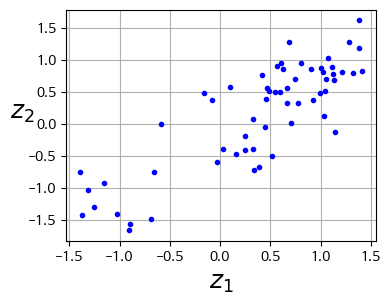

In [5]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

원본 3D 데이터셋을 분산이 가장 큰 2D로 투영하였다.

# 17.3 적층 오토인코더

# 케라스로 적층 오토인코더 구현하기

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
tf.random.set_seed(42)

In [8]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])

In [9]:
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

In [10]:
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid), verbose=0)

# 재구성 시각화

오토인코더가 적절히 훈련되었는지 확인하기 위해 입력과 출력을 비교한다. 입력과 출력의 차이가 너무 크지 않아야 한다.

In [11]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 107ms/step


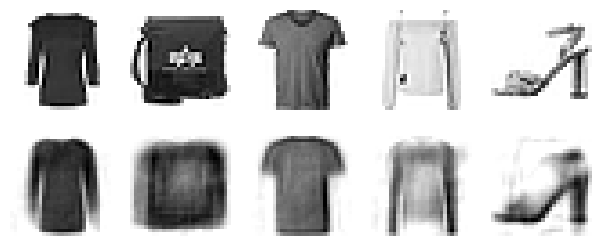

In [12]:
plot_reconstructions(stacked_ae)

재구성된 이미지는 784개에서 30개의 숫자로 압축되었다.

# 패션 MNIST 데이터셋 시각화

In [13]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 2ms/step


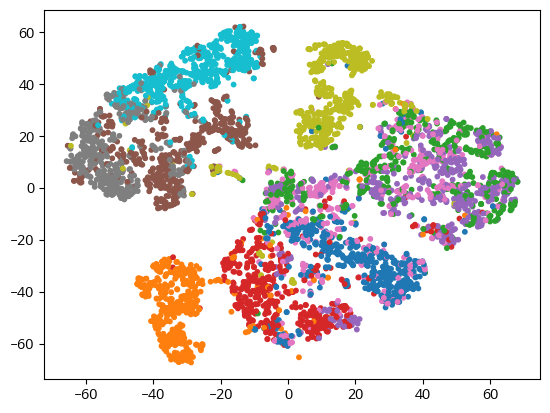

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

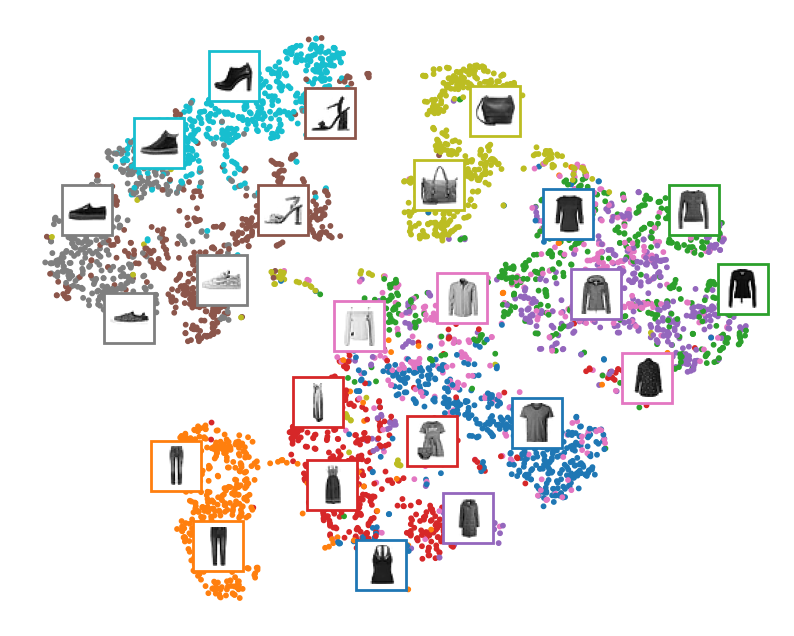

In [15]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # 0-1 범위로 정규화
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # 다른 이미지와 충분히 멀리 떨어져 있는 경우
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

# 가중치 묶기

인코더 가중치의 전치를 디코더 가중치로 사용하여 인코더와 디코더의 가중치를 묶는 것이 일반적이다.

In [16]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

transpose_b=True로 지정하는 것이 두 번째 매개변수를 전치하는 것과 동일하지만 matmul() 연산에서 동적으로 전치를 수행하므로 훨씬 효율적이다.

이 디코더의 Dense 층은 인코더의 Dense 층과 묶여있다.

In [17]:
tf.random.set_seed(42)

In [18]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

In [19]:
tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

In [20]:
tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid), verbose=0)

1/1 [==============================] - 0s 80ms/step


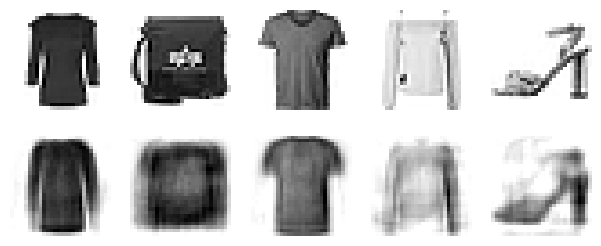

In [21]:
plot_reconstructions(tied_ae)
plt.show()

# 17.4 합성곱 오토인코더

3개의 은닉 층과 1개의 출력 층으로 구성된 적층 오토인코더

인코더는 합성곱 층과 풀링 층으로 구성된 일반적인 CNN이다.

In [22]:
tf.random.set_seed(42)

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),    # 출력: 14 x 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),    # 출력: 7 x 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),    # 출력: 3 x 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()    # 출력: 30
])

In [23]:
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])

In [24]:
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

In [25]:
conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid), verbose=0)

1/1 [==============================] - 0s 178ms/step


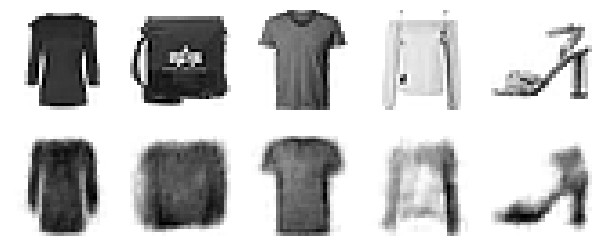

In [26]:
plot_reconstructions(conv_ae)
plt.show()

# 순환 오토인코더

각 패션 MNIST 이미지를 각각 28개의 차원을 가진 28개의 벡터 시퀀스로 취급해보자

In [27]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])

In [28]:
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])

In [ ]:
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid), verbose=0)

In [ ]:
plot_reconstructions(recurrent_ae)
plt.show()

# 17.5 잡음 제거 오토인코더

오토인코더가 유용한 특성을 학습하도록 강제하는 방법으로 입력에 잡음을 추가하고 잡음이 없는 원본 입력을 복원하도록 훈련하는 방법이 있다.

잡음은 입력에 순수한 가우스 잡음을 입력에 추가하거나 드롭아웃처럼 랜덤으로 입력을 꺼서 발생시킬 수 있다.

In [ ]:
# 드롭아웃 사용
tf.random.set_seed(42)

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])

In [ ]:
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

In [ ]:
dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid), verbose=0)

In [ ]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

# 17.6 희소 오토인코더

비용 함수에 적절한 항을 추가하여 오토인코더가 코딩 층에서 활성화된느 뉴런 수를 감소시키도록 만든다.

코딩 레이어에서 시그모이드 활성화 함수를 사용한다. 여기에 l1 정규화도 추가한다.

In [ ]:
tf.random.set_seed(42)

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid), verbose=0)

In [ ]:
plot_reconstructions(sparse_l1_ae)
plt.show()

KL 발산 손실과 MAE 및 MSE를 비교한 그래프

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "타깃\n희소 정도", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL 발산")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("실제 희소 정도")
plt.ylabel("비용", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)

In [ ]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

# KL-발산 규제를 이용하는 사용자 정의 클래스
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
tf.random.set_seed(42)

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid), verbose=0)

In [ ]:
plot_reconstructions(sparse_kl_ae)
plt.show()

# 17.7 변이형 오토인코더

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)

In [ ]:
codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)    # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)    # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
latent_loss

In [ ]:
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [ ]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid), verbose=0)

In [ ]:
plot_reconstructions(variational_ae)
plt.show()

# 패션 MNIST 이미지 생성하기

이 변이형 오토인코더를 사용해 패션 의류처럼 보이는 이미지를 생성한다. 해야 할 일은 가우스 분포에서 랜덤한 코딩을 샘플링하여 디코딩하는 것이다.

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()

이제 두 이미지 사이에 시맨틱 보간을 수행

In [ ]:
tf.random.set_seed(42)

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)
images = variational_decoder(codings).numpy()

In [ ]:
plot_multiple_images(images)
plt.show()

# 17.8 생성적 적대 신경망

In [ ]:
tf.random.set_seed(42)

codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])

In [ ]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])

In [ ]:
gan = tf.keras.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"에포크 {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            # 1단계 - 판별자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            # 2단계 - 생성자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

        # 훈련 중 이미지 출력
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

In [ ]:
plot_multiple_images(generated_images, 8)
plt.show()

# 심층 합성곱 GAN (DCGAN)

In [ ]:
tf.random.set_seed(42)

In [ ]:
codings_size = 100

In [ ]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])

In [ ]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
gan = tf.keras.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.    # 크기 변경 및 스케일 조정

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

In [ ]:
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)

# 17.9 확산 모델

prepare_batch() 함수는 이미지 배치를 가져와 각 이미지에 대해 1에서 T 사이의 다른 임의 시간을 사용하여 각 이미지에 잡음을 추가하고 입력과 타깃을 포함하는 튜플을 반환한다.

In [ ]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1    # -1에서 1까지 스케일링
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T+1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

이제 훈련과 검증을 위한 tf.data.Dataset을 준비한다.

In [ ]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

In [ ]:
tf.random.set_seed(43)
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

In [ ]:
def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("원본 이미지")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("타임 스텝:", X_dict["time"].numpy()[:8])
print("잡음 이미지")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("예측할 잡음")
plot_multiple_images(Y_noise[:8].numpy())
plt.show()

이제 확산 모델 자체를 구축할 준비가 되었습니다. 이미지와 시간을 모두 처리해야 합니다. DDPM 논문에서 제안한 대로 트랜스포머 논문에서처럼 사인파 인코딩을 사용하여 시간을 인코딩합니다. 시간 인덱스(정수)를 나타내는 m 정수의 벡터가 주어지면 이 층은 m × d 행렬을 반환하며, 여기서 _d_는 선택한 임베딩 크기입니다.

In [ ]:
# 추가 코드 - 사용자 정의 시간 인코딩 층을 구현합니다.

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

이제 모델을 빌드해 보겠습니다. 개선된 DDPM 문서에서는 UNet 모델을 사용합니다. Conv2D + BatchNormalization 층을 통해 이미지를 처리하고 스킵 연결을 가진 UNet과 유사한 모델을 만들어 보겠습니다. 점차적으로 이미지 다운샘플링(strides=2인 MaxPooling 층을 사용)한 다음 다시 업샘플링합니다(Upsampling2D 층 사용). 다운샘플링 부분과 업샘플링 부분에 스킵 연결이 추가됩니다. 또한 Dense 레이어를 통과하여 올바른 크기로 크기를 조정한 후 각 블록의 출력에 시간 인코딩을 추가합니다.

In [ ]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)    # 시간 인코딩 적용
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z     # 모든 픽셀에 시간 데이터 추가

    skip = Z
    cross_skips = []    # UNet의 다운샘플링 & 업샘플링을 가로지르는 스킵 연결

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

In [ ]:
tf.random.set_seed(42)
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model",
                                                   save_best_only=True)

In [ ]:
history = model.fit(train_set, validation_data=valid_set, epochs=50,
                    callbacks=[checkpoint_cb], verbose=0)

In [ ]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # 추가 코드 - 진행률 표시
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

In [ ]:
tf.random.set_seed(42)
X_gen = generate(model)

In [ ]:
plot_multiple_images(X_gen.numpy(), 8)
plt.show()

# 이진 오토인코더를 사용한 해싱

인코더에 16개의 뉴런으로 구성된 출력 층과 시그모이드 활성화 함수를 사용하고 바로 그 전에 가우스 잡음을 추가한 오토인코더

훈련 중에 잡음 층은 이전 층이 큰 값을 출력하도록 권장한다. 작은 값은 잡음에 의해 희석되기 때문이다.

시그모이드 활성화 함수로 출력이 0또는 1에 가까운 값을 출력하게 되는데 출력 값을 0과 1로 반올림하면 16비트 "시맨틱" 해시를 얻을 수 있다.

In [ ]:
tf.random.set_seed(42)

hashing_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.GaussianNoise(15.),
    tf.keras.layers.Dense(16, activation="sigmoid"),
])

In [ ]:
hashing_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

In [ ]:
hashing_ae = tf.keras.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="mse", optimizer="nadam")
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid), verbose=0)

In [ ]:
plot_reconstructions(hashing_ae)
plt.show()

검증 세트의 이미지에 대한 해시가 어떻게 보이는지

In [ ]:
hashes = hashing_encoder.predict(X_valid).round().astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print(f"{h:016b}")
print("...")

In [ ]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plt.show()